## Check the GPU

In [1]:
!nvidia-smi

Tue Sep 17 16:50:26 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0    56W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import libraries

In [2]:
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Input, ReLU, Lambda, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Renewed Batch Norm
from batchnorm import *

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.set_session(tf.Session(config=config))

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR'
from clr import OneCycleLR, LRFinder

## Downloading Dataset

In [3]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## View Data

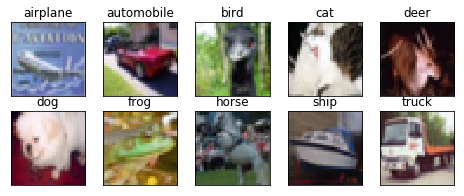

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Setting Hyperparams

In [5]:
hparams = HParams(
    learning_rate= 0.4,  # fixed learning rate
    batch_size= 512,  # training batch size
    momentum = 0.9, # fixed momentum
    n_epochs= 24,  # number of epochs to train
    decay = 1e-04 # learning rate*batch size
)

## Image Normalization and One hot encoding

In [6]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [7]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

## Network Architecture (ResNet 9)

In [8]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [9]:
def Resnet9(input_dim, n_classes): 
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        x = Conv2D(filters = channels[layer_name], 
                   kernel_size = 3, 
                   strides = 1, 
                   padding = 'same',
                   kernel_initializer=init_pytorch,
                   kernel_regularizer=l2(hparams.decay),
                   use_bias=False)(x)
        #x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = BatchNorm()(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPooling2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams.decay),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(lambda x : x * 0.2)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams.learning_rate, momentum= hparams.momentum, 
                              nesterov=True),
                metrics=['accuracy'])
    return model

### With Original BatchNorm

In [10]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### With Modified BatchNorm

In [10]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

W0917 16:38:37.348544 139668422256448 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm (BatchNorm)          (None, 32, 32, 64)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_norm[0][0]                 
______________________________________________________________________________________________

**Less number of parameters than Original BatchNorm**

### Without BatchNorm

In [10]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  73728       re_lu[0][0]                      
______________________________________________________________________________________________

## Finding Max Learning rate for OneCycle LR

In [ ]:
lr_callback = LRFinder(num_train, batch_size=512, lr_scale='exp', save_dir='.')
net.fit(X_train, y_train, epochs=1, batch_size=512, callbacks=[lr_callback])

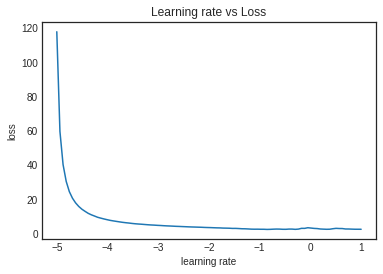

In [ ]:
LRFinder.plot_schedule_from_file('.')

Its not clear from the graph, although we see a bump near 0.5. We will go with prescribed max lr of 0.4.

## Model Training 

### With original Batch_Norm

In [11]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", verbose=0, 
                               save_best_only=True, monitor="val_acc")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams.learning_rate, 
                        maximum_momentum=hparams.momentum, verbose=False)

# Fit the model
history = net.fit_generator(datagen.flow(X_train, y_train, 
                                         batch_size= hparams.batch_size, 
                                         shuffle=True), 
                            epochs = hparams.n_epochs, 
                            steps_per_epoch= np.ceil(X_train.shape[0]/hparams.batch_size),
                            validation_data=(X_test, y_test),
                            callbacks = [lr_manager, checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 14s 141ms/step - loss: 1.4888 - acc: 0.4833 - val_loss: 1.3137 - val_acc: 0.5635
Epoch 2/24
98/98 [==============================] - 8s 81ms/step - loss: 0.8852 - acc: 0.7086 - val_loss: 0.8581 - val_acc: 0.7282
Epoch 3/24
98/98 [==============================] - 8s 83ms/step - loss: 0.6899 - acc: 0.7836 - val_loss: 0.7153 - val_acc: 0.7777
Epoch 4/24
98/98 [==============================] - 8s 81ms/step - loss: 0.5957 - acc: 0.8185 - val_loss: 0.7888 - val_acc: 0.7583
Epoch 5/24
98/98 [==============================] - 8s 82ms/step - loss: 0.5506 - acc: 0.8394 - val_loss: 0.6070 - val_acc: 0.8259
Epoch 6/24
98/98 [==============================] - 8s 80ms/step - loss: 0.5126 - acc: 0.8556 - val_loss: 0.7792 - val_acc: 0.7840
Epoch 7/24
98/98 [==============================] - 8s 81ms/step - loss: 0.4942 - acc: 0.8677 - val_loss: 0.6953 - val_acc: 0.8079
Epoch 8/24
98/98 [==============================] - 8s 83ms/step - loss: 0.4805 -

### With Modified Batch_Norm

In [11]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", verbose=0, 
                               save_best_only=True, monitor="val_acc")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams.learning_rate, 
                        maximum_momentum=hparams.momentum, verbose=False)
# train the model
start = time.time()

# Fit the model
history = net.fit_generator(datagen.flow(X_train, y_train, 
                                         batch_size= hparams.batch_size, 
                                         shuffle=True), 
                            epochs = hparams.n_epochs, 
                            steps_per_epoch= np.ceil(X_train.shape[0]/hparams.batch_size),
                            validation_data=(X_test, y_test),
                            callbacks = [lr_manager])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 15s 158ms/step - loss: 1.4604 - acc: 0.4906 - val_loss: 1.2655 - val_acc: 0.5758
Epoch 2/24
98/98 [==============================] - 9s 93ms/step - loss: 0.8939 - acc: 0.7059 - val_loss: 0.8498 - val_acc: 0.7259
Epoch 3/24
98/98 [==============================] - 9s 93ms/step - loss: 0.7061 - acc: 0.7763 - val_loss: 0.7705 - val_acc: 0.7619
Epoch 4/24
98/98 [==============================] - 9s 93ms/step - loss: 0.6198 - acc: 0.8118 - val_loss: 0.7211 - val_acc: 0.7742
Epoch 5/24
98/98 [==============================] - 9s 93ms/step - loss: 0.5585 - acc: 0.8368 - val_loss: 0.7106 - val_acc: 0.7910
Epoch 6/24
98/98 [==============================] - 9s 94ms/step - loss: 0.5227 - acc: 0.8535 - val_loss: 0.8385 - val_acc: 0.7612
Epoch 7/24
98/98 [==============================] - 9s 94ms/step - loss: 0.5103 - acc: 0.8616 - val_loss: 0.5510 - val_acc: 0.8509
Epoch 8/24
98/98 [==============================] - 9s 93ms/step - loss: 0.4797 -

### Without Batch_Norm

In [11]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", verbose=0, 
                               save_best_only=True, monitor="val_acc")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams.learning_rate, 
                        maximum_momentum=hparams.momentum, verbose=False)

# Fit the model
history = net.fit_generator(datagen.flow(X_train, y_train, 
                                         batch_size= hparams.batch_size, 
                                         shuffle=True), 
                            epochs = hparams.n_epochs, 
                            steps_per_epoch= np.ceil(X_train.shape[0]/hparams.batch_size),
                            validation_data=(X_test, y_test),
                            callbacks = [lr_manager, checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 11s 117ms/step - loss: 2.2625 - acc: 0.1681 - val_loss: 2.2667 - val_acc: 0.2275
Epoch 2/24
98/98 [==============================] - 7s 74ms/step - loss: 1.9551 - acc: 0.3232 - val_loss: 1.7183 - val_acc: 0.4119
Epoch 3/24
98/98 [==============================] - 8s 78ms/step - loss: 1.6905 - acc: 0.4215 - val_loss: 1.6343 - val_acc: 0.4116
Epoch 4/24
98/98 [==============================] - 8s 78ms/step - loss: 1.6362 - acc: 0.4503 - val_loss: 1.4026 - val_acc: 0.5250
Epoch 5/24
98/98 [==============================] - 8s 77ms/step - loss: 1.3151 - acc: 0.5670 - val_loss: 1.3984 - val_acc: 0.5676
Epoch 6/24
98/98 [==============================] - 8s 78ms/step - loss: 1.1720 - acc: 0.6281 - val_loss: 0.9267 - val_acc: 0.7167
Epoch 7/24
98/98 [==============================] - 8s 77ms/step - loss: 1.0577 - acc: 0.6719 - val_loss: 1.0654 - val_acc: 0.6776
Epoch 8/24
98/98 [==============================] - 7s 76ms/step - loss: 0.9432 -

## Model Evaluation

In [12]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel.h5", custom_objects={'init_pytorch': init_pytorch})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams.batch_size, verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

W0917 16:49:01.065085 140624690571072 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0917 16:49:01.067139 140624690571072 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000/10000 [==============================] - 0s 49us/sample - loss: 0.3698 - acc: 0.9335
Minimal Validation Loss :  0.3698475227355957
Max Validation Accuracy: 93.34999918937683 %


## Plot Loss and Accuracy History

In [13]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

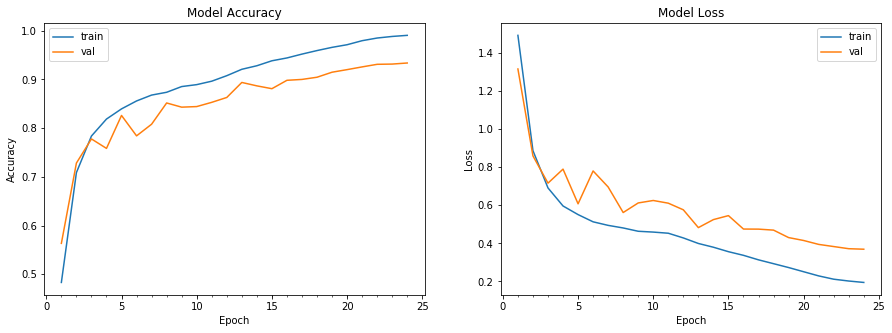

In [14]:
# plot model history
plot_model_history(history)

## Misclassified Images

In [15]:
#Prediction on validation dataset
valid_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=hparams.batch_size,
                                            shuffle=False, seed=101)
pred_valid = net.predict_generator(valid_generator, steps= np.ceil(X_test.shape[0]/512), 
                                         verbose=0)
pred_labels = np.argmax(pred_valid, axis=1)
pred_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [16]:
# True labels of validation dataset
true_labels = np.argmax(y_test,axis=1)
true_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [17]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_labels, pred_labels))

[[942   5  17   4   3   0   1   1  22   5]
 [  3 973   0   0   0   0   0   0   3  21]
 [ 16   0 913  20   9  17  17   6   2   0]
 [  6   3  15 863  21  64  13   5   5   5]
 [  2   0  12  14 946  12   3  10   0   1]
 [  3   1  11  59  17 895   5   8   0   1]
 [  4   1  15  20   2   6 949   2   0   1]
 [  5   0   5   6  13  17   3 948   1   2]
 [ 18   6   3   3   0   0   0   0 960  10]
 [  8  29   2   2   0   1   1   0  11 946]]


In [18]:
# Total number of false predictions
mislabelled_index = []

for i in range(true_labels.shape[0]):
    if pred_labels[i] != true_labels[i]:
        mislabelled_index.append(i)

print('Number of False predictions: ', len(mislabelled_index),'out of', len(test_labels))

Number of False predictions:  665 out of 10000
